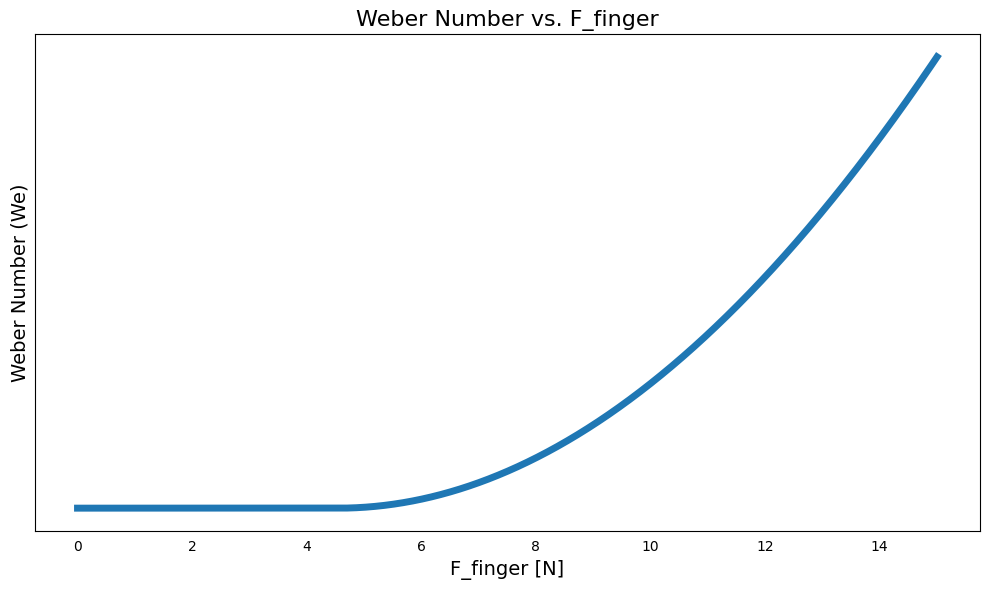

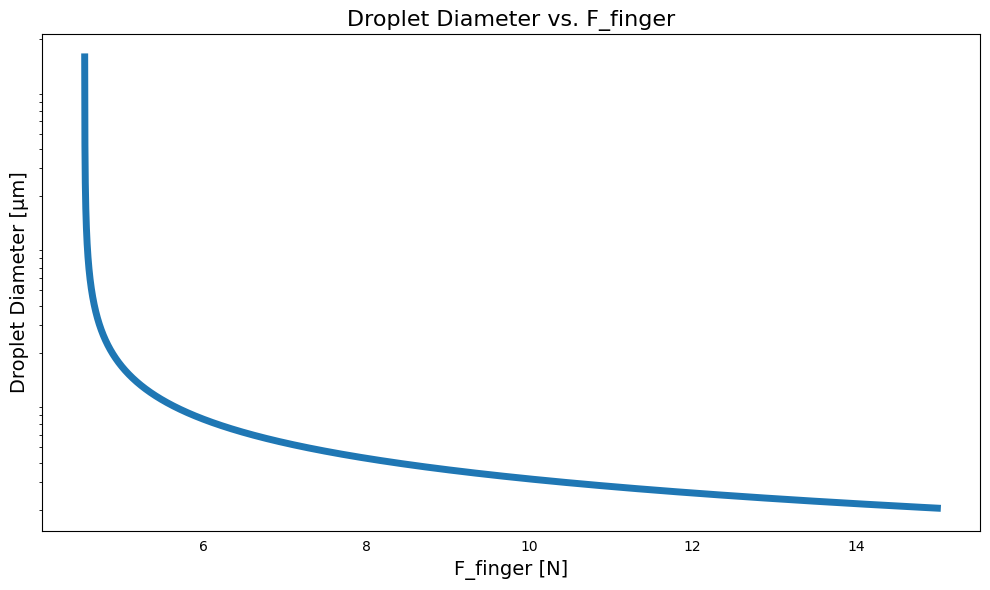

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 고정 변수들
m = 0.02  # kg
x_limit = 10e-3  # m
D1 = 2.4e-3
D2 = 0.2e-3
L1 = 20.87e-3
L2 = 5.0e-3
k1 = 2660  # N/m
k2 = 1260  # N/m
L_open = 1.0e-3
t_final = 0.1

K = 0.9
f_pipe = 0.03
A_in = (np.pi / 4) * D1**2
rho = 1000
g = 9.81
sigma = 0.0728
f_gap = 0.3
E = 1e9
delta_gap = 0.001e-3
h_packing = 1e-3

# 병렬 스프링 등가 강성
k = (k1 * k2) / (k1 + k2)

# D_chamber 고정
D_chamber = 0.01
A_chamber = (np.pi / 4) * D_chamber**2

# 손가락 힘 변화 범위
F_fingers = np.linspace(0, 15, 1000)  # 0 제외

# 결과 저장
v_avg_array = []
t_stop_array = []
We_array = []
D_particle_array = []

for F_finger in F_fingers:
    # 반복 기반 고정점 수렴법
    v_avg = 1.0
    tolerance = 1e-4
    max_iter = 10
    A_wall = np.pi * D_chamber * x_limit
    F_friction = 2 * np.pi * f_gap * E * delta_gap * h_packing
    F_open = k1 * L_open

    for _ in range(max_iter):
        c = (rho * v_avg * A_chamber) / 2
        F_muf = A_wall * (f_pipe * (x_limit / D_chamber) * (1 / (2 * g)) * v_avg**2)
        F_total = F_finger - F_friction - F_muf - F_open

        if F_total <= 0:
            v_avg = 0
            break

        def mck_system(t, y):
            x, v = y
            dxdt = v
            dvdt = (F_total - c * v - k * x) / m
            return [dxdt, dvdt]

        sol = solve_ivp(mck_system, (0, t_final), [0.0, 0.0], t_eval=np.linspace(0, t_final, 1000))
        v_new = np.mean(sol.y[1])

        if abs(v_new - v_avg) < tolerance:
            break
        v_avg = v_new

    t_stop = sol.t[-1]

    # Weber 수 계산
    geom_term = np.sqrt((1 - f_pipe * L1 / D1) * (1 - K) * (1 - f_pipe * L2 / D2))
    A_term = ((rho * D2 / sigma) * ((A_chamber / A_in) * geom_term))**2
    B_term = max(F_total, 0)**2

    c_val = (rho * v_avg * A_chamber) / 2
    zeta = c_val / (2 * np.sqrt(m * k2))
    omega_n = np.sqrt(k2 / m)
    omega_d = omega_n * np.sqrt(max(1 - zeta**2, 1e-6))

    exp_term = np.exp(-zeta * omega_n * t_stop)
    dyn_term = (
        zeta * omega_n * (np.cos(omega_d * t_stop) + (zeta * omega_n / omega_d) * np.sin(omega_d * t_stop))
        - omega_d * (-np.sin(omega_d * t_stop) + (zeta * omega_n / omega_d) * np.cos(omega_d * t_stop))
    )
    C_term = ((exp_term / k2)**2) * (dyn_term**2)

    We = A_term * B_term * C_term
    D_particle = 1.95 * D2 * (1.293 / rho)**(-1/6) * (We**(-1/3)) if We > 0 else np.nan

    # 결과 저장
    v_avg_array.append(v_avg)
    t_stop_array.append(t_stop)
    We_array.append(We)
    D_particle_array.append(D_particle)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(F_fingers, We_array, lw=5)
plt.xlabel('F_finger [N]', fontsize=14)
plt.ylabel('Weber Number (We)', fontsize=14)
plt.title('Weber Number vs. F_finger', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(F_fingers, np.array(D_particle_array) * 1e6, lw=5)
plt.xlabel('F_finger [N]', fontsize=14)
plt.ylabel('Droplet Diameter [µm]', fontsize=14)
plt.title('Droplet Diameter vs. F_finger', fontsize=16)
plt.yscale("log")
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.tight_layout()
plt.show()
